# Clustering des Vehicules

L'objectif est d'attribuer des categories, à l'aide d'un modèle de clustering, aux vehicules decrit dans le fichier Catalogue_cleaned_local.csv, qui contient les infos sur les vehicules avec les infos CO2 et de prédire les catégories des vehicules contenu dans Immatriculation.csv à l'aide du modèle obtenu

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.cm as cm
import pickle
import json
from scipy.spatial import ConvexHull
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
""" Fonction de scoring """
def custom_silhouette_scorer(estimator, X):      
    labels = estimator.predict(X)
    score = silhouette_score(X, labels)
    return score

## Fonctions

In [25]:
def reduce_to_2d_and_show(X,show=True,get_reduces=False):
    X_pca = PCA(n_components=2).fit_transform(X)
    X_ts = TSNE(n_components=2).fit_transform(X)
    if show:
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.scatter(X_pca[:,0],X_pca[:,1])
        ax1.set_title("Avec PCA")
        ax2.scatter(X_ts[:,0],X_ts[:,1])
        ax2.set_title("Avec TSNE")
        plt.suptitle("Nuage de points des données transformées",fontweight="bold")
        plt.show()
    if get_reduces:
        return X_pca, X_ts

def c_silhouette_score(estimator, X):
    return metrics.silhouette_score(X, estimator.fit_predict(X))
    
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def get_center_clusters(n_clusters, cluster_labels, X):
    center_clusters = []
    for i in range(n_clusters):
        points = X[cluster_labels == i]        
        x_mean = np.mean(points[:,0])
        y_mean = np.mean(points[:,1])
        center_clusters.append(np.array(centeroidnp(points)))
    return np.array(center_clusters)

def show_inertie(data):
    min_clusters = 2
    max_clusters = 7
    inertie = []
    for k in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=k).fit(data)
        inertie.append(kmeans.inertia_)
    max_intertie = int(max(inertie))
    plt.figure(figsize=(10, 7))
    plt.plot(range(min_clusters, max_clusters), inertie, marker='+');
    plt.xlabel('Nombre de cluster')
    plt.ylabel('Inertie')
    plt.xticks(range(min_clusters,max_clusters))
    plt.show()

def show_cluster_content(n_clusters,vehicules_categorie,labels):
    vehicules_categorie["categorie_label"] = labels
    vehicules_groups = vehicules_categorie.groupby("categorie_label")
    clusters_name = [f"Cluster {i}" for i in range(n_clusters)]
    #index = ["marques","noms","puissances","prix","longueurs","nbPlaces","nbPortes","bonus_malus","rejets_co2_gkm","cout_energie","nbVehicules"]
    index = ["marques","noms","puissances","prix","longueurs","nbPlaces","nbPortes","nbVehicules"]

    clusters_data = pd.DataFrame(index=index,columns=clusters_name)
    for i, vehicules_group in vehicules_groups:
        col = [] 
        col.append(str(vehicules_group.marque.unique()))
        col.append(str(vehicules_group.nom.unique()))
        col.append(f"{vehicules_group.puissance.min()}-{vehicules_group.puissance.max()}")
        col.append(f"{vehicules_group.prix.min()}-{vehicules_group.prix.max()}")
        col.append(str(vehicules_group.longueur.unique()))
        col.append(vehicules_group.nbPlaces.mode()[0])
        col.append(vehicules_group.nbPortes.mode()[0])
        #col.append(f"{vehicules_group.bonus_malus.min()}-{vehicules_group.bonus_malus.max()}")
        #col.append(f"{vehicules_group.rejets_co2_gkm.min()}-{vehicules_group.rejets_co2_gkm.max()}")
        #col.append(f"{vehicules_group.cout_energie.min()}-{vehicules_group.cout_energie.max()}")
        col.append(vehicules_group.shape[0])
        clusters_data.iloc[:,i] = col 
    display(clusters_data)

def show_cluster(config_name,n_clusters,X_train,estimator):
    # Réduction des dimensions
    pca = PCA(n_components=2)
    ts = TSNE(n_components=2)
    X_pca = pca.fit_transform(X_train)
    X_ts = ts.fit_transform(X_train)
    silhouette_score = metrics.silhouette_score(X_train, estimator.labels_, metric='euclidean')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(20, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])
    cluster_labels = estimator.labels_
    sample_silhouette_values =  metrics.silhouette_samples(X_train, cluster_labels)
    nb_bad_sample = (sample_silhouette_values <= 0).sum()
    silhouette_score_ratio = int(silhouette_score * 100)
    bad_sample_ratio = int((nb_bad_sample / sample_silhouette_values.shape[0]) * 100)
    print(f"{config_name} silhouette_score: {silhouette_score}")
    print(f"Taux de points mal classé: {bad_sample_ratio}%")
    print()
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title(f"{config_name} - Evaluation de la silhouette [score:{silhouette_score_ratio}|Taux points mals classés:{bad_sample_ratio}%]")
    ax1.set_xlabel("Coefficient de silhouette")
    ax1.set_ylabel("Label du cluster")
    ax1.axvline(x=silhouette_score, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)      
    center_clusters_pca = get_center_clusters(n_clusters, cluster_labels, X_pca)
    center_clusters_ts = get_center_clusters(n_clusters, cluster_labels, X_ts)
    # PCA
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
    ax2.scatter(center_clusters_pca[:, 0],center_clusters_pca[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k")
    ax2.set_title(f"{config_name} - PCA Visualisation des données")
    for i, c in enumerate(center_clusters_pca):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    # TSNE
    ax3.scatter(X_ts[:, 0], X_ts[:, 1], c=colors)
    ax3.scatter(center_clusters_ts[:, 0],center_clusters_ts[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k")
    ax3.set_title(f"{config_name} - TSNE Visualisation des données")
    for i, c in enumerate(center_clusters_ts):
        ax3.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    plt.show()

def show_cluster2(config_name,n_clusters,X_train,labels):
    # Réduction des dimensions
    pca = PCA(n_components=2)
    ts = TSNE(n_components=2)
    X_pca = pca.fit_transform(X_train)
    X_ts = ts.fit_transform(X_train)
    silhouette_score = metrics.silhouette_score(X_train,labels, metric='euclidean')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(20, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])
    cluster_labels = labels
    sample_silhouette_values =  metrics.silhouette_samples(X_train, cluster_labels)
    nb_bad_sample = (sample_silhouette_values <= 0).sum()
    silhouette_score_ratio = int(silhouette_score * 100)
    bad_sample_ratio = int((nb_bad_sample / sample_silhouette_values.shape[0]) * 100)
    print(f"{config_name} silhouette_score: {silhouette_score}")
    print(f"Taux de points mal classé: {bad_sample_ratio}%")
    print()
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title(f"{config_name} - Evaluation de la silhouette [score:{silhouette_score_ratio}|Taux points mals classés:{bad_sample_ratio}%]")
    ax1.set_xlabel("Coefficient de silhouette")
    ax1.set_ylabel("Label du cluster")
    ax1.axvline(x=silhouette_score, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)      
    center_clusters_pca = get_center_clusters(n_clusters, cluster_labels, X_pca)
    center_clusters_ts = get_center_clusters(n_clusters, cluster_labels, X_ts)
    # PCA
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
    ax2.scatter(center_clusters_pca[:, 0],center_clusters_pca[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k")
    ax2.set_title(f"{config_name} - PCA Visualisation des données")
    for i, c in enumerate(center_clusters_pca):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    # TSNE
    ax3.scatter(X_ts[:, 0], X_ts[:, 1], c=colors)
    ax3.scatter(center_clusters_ts[:, 0],center_clusters_ts[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k")
    ax3.set_title(f"{config_name} - TSNE Visualisation des données")
    for i, c in enumerate(center_clusters_ts):
        ax3.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    plt.show()

# Chargement des données

In [3]:
catalogue = pd.read_csv("data/Catalogue_cleaned_local.csv", encoding='utf-8')

## Entrainement du modèle de clustering

### Préparation des données

On retire les valeur abérantes.

In [4]:
X = catalogue.copy()
X = catalogue[catalogue.prix < catalogue.prix.quantile(0.995)]

A ce stage le données sont transformées on peut passer au choix du modèle de clustering.

### Entrainement et Choix du modèle

Nous avons sélection 4 modèles pour l'entrainement des données :

- Kmeans
- KPrototypes
- AgglomerativeClustering
- GaussianMixture

Suite à notre analyse exploratoire nous avons décider de fixer nombre de cluster à 4 ou 5. On entraine les modèles avec une grille de validation et le meilleur modèle sera sélectionné sur la base de sa meilleur silouhette obtenu avec GridSearch (train_score_silouhette) et la silouhette obtenu après la prédiction des clusters avec le meilleur modèle (test_score_silouhette).

**Les entrainements et les résultats ont été éffectué dans le notebooks 12_clustering. Toutes les informations utiles pour le traintement y ont été consigné.**

In [8]:
from sklearn.cluster import KMeans

##### Definition des features
selector_features = ["prix","puissance"]
onehot_features = ["longueur","occasion","nbPlaces","nbPortes"]

##### Definition des transformeurs
numeric_transformer = Pipeline(steps=[('scaler', preprocessing.StandardScaler())])
onehot_transformer = Pipeline(steps=[('onehot', preprocessing.OneHotEncoder())])

#### Definition de la pipeline de transformation
tranformaters = ColumnTransformer(
    transformers=[
        ('scaler_transform',"passthrough",selector_features),
        ('onehot_transform', onehot_transformer, onehot_features)
    ])

#### Definition de la pipeline
pipeline = Pipeline(steps=[('tranformations', tranformaters)])

#### fit de la pipeline
pipeline.fit(X)

#### Transformation des données
X_train = pipeline.transform(X)

### Visualisation des données
#display(pd.DataFrame(X_train).head(1))
#reduce_to_2d_and_show(X_train)

#### Paramètres
params = {'init': 'random', 'max_iter': 100, 'n_clusters': 5, 'n_init': 2, 'random_state': 3, 'tol': 0.0001}

#### Entrainement
kmeans = KMeans()
kmeans.set_params(**params)
kmeans.fit(X_train)

#### Modèle
model = kmeans

### Visualisation des données

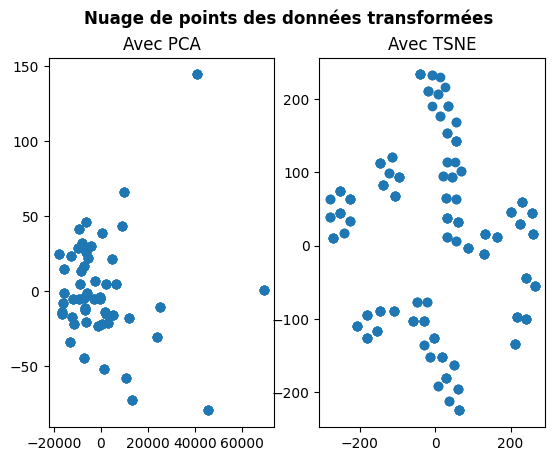

In [9]:
reduce_to_2d_and_show(X_train)

Kmeans-5 silhouette_score: 0.6232867855648497
Taux de points mal classé: 0%



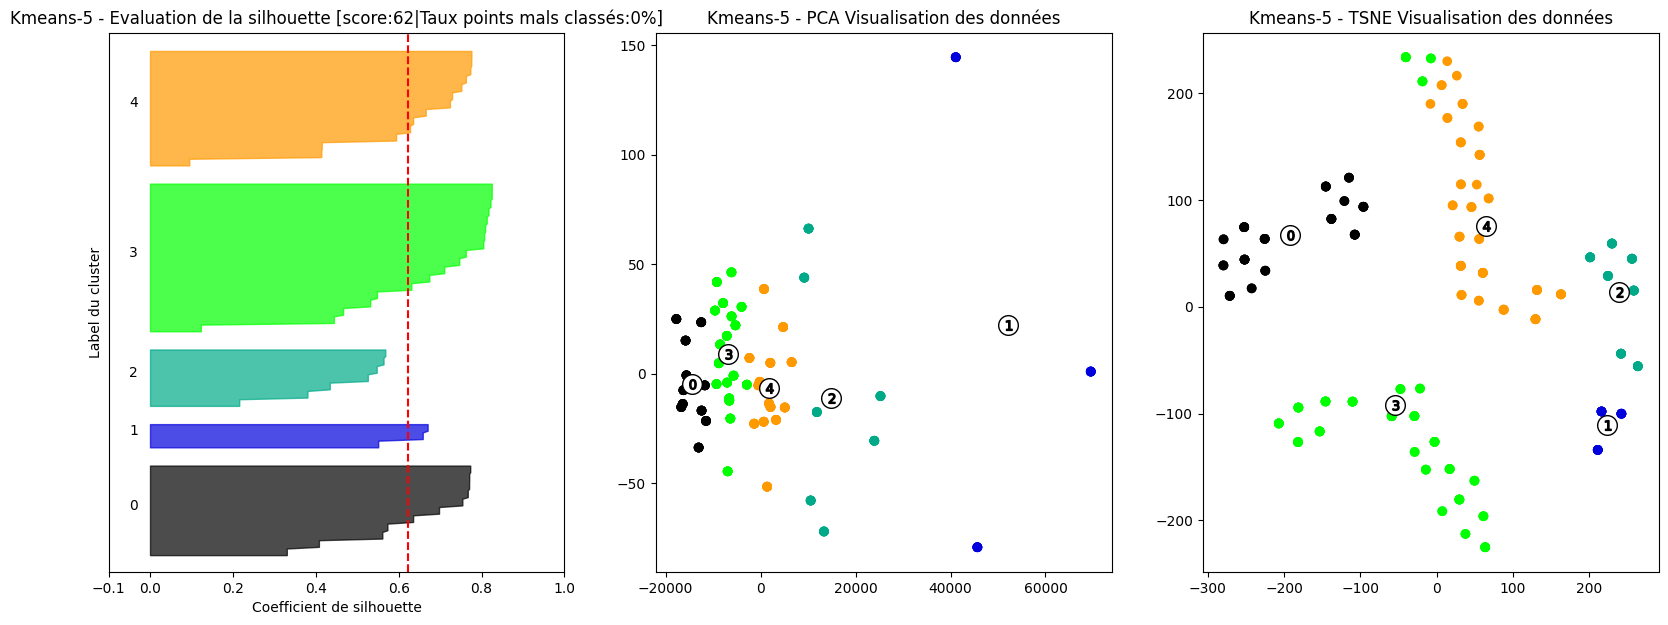

In [10]:
show_cluster("Kmeans-5",5,X_train,model)

### Description du modèle

Predit les cluster associé à chaque vehicule et on observe la composition des clusters

In [11]:
categorieClusteringModel = model
vehicules_categorie = catalogue.copy()
data = pipeline.transform(vehicules_categorie)
labels = categorieClusteringModel.predict(data)
silhouette_avg = metrics.silhouette_score(data,labels) 
print("L'indice de silhouette est :", silhouette_avg)
show_cluster_content(5,vehicules_categorie,labels)

L'indice de silhouette est : 0.6181173547759082


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
marques,['Volkswagen' 'Peugeot' 'Mini' 'Lancia' 'Kia' ...,['Mercedes' 'BMW'],['Volvo' 'Saab' 'Renault' 'Jaguar' 'BMW'],['Volkswagen' 'Seat' 'Renault' 'Nissan' 'Mini'...,['Volkswagen' 'Skoda' 'Saab' 'Renault' 'Nissan...
noms,['Polo 1.2 6V' '1007 1.4' 'Copper 1.6 16V' 'Yp...,['S500' 'M5'],['S80 T6' '9.3 1.8T' 'Vel Satis 3.5 V6' 'X-Typ...,['Touran 2.0 FSI' 'New Beatle 1.8' 'Golf 2.0 F...,['Touran 2.0 FSI' 'New Beatle 1.8' 'Golf 2.0 F...
puissances,55-115,306-507,150-272,75-170,110-200
prix,7500-13750,66360-101300,34440-50500,15644-22350,22900-31790
longueurs,['courte' 'moyenne'],['très longue'],['très longue' 'longue' 'moyenne'],['longue' 'moyenne' 'courte'],['longue' 'moyenne' 'très longue']
nbPlaces,5,5,5,5,5
nbPortes,5,5,5,5,5
nbVehicules,55,20,35,90,70


**Analyse**

* Le Cluster 0, contient les voitures de taille moyenne, avec prix et puissance moyen
* Le cluster 1, contient les voitures petite taille et les moins chère (Les prix sont abordables mais il y'a des modèles plus chère)
* Le cluster 2, contient les voitures puissantes, plus robuste, et plus luxieuse, donc les plus chères
* Le Cluster 3, contient les voitures de grande taille, spacieuse et puissance (Les prix sont abordable mais il y'a des modèle plus chère)


**Attribution des noms des catégories**

* **Cluster 0** : Standard
* **Cluster 1** : Citadine
* **Cluster 2** : Luxe et Sportive
* **Cluster 3** : Familiale


In [36]:
categories_map = {
    0:"Citadine",
    1:"Haut de gamme",
    2:"Familliale",
    3:"Economique",
    4:"Moyen"
}

## Attribution des categories dans Immatriculation

On prédit les clusters (categories) des vehicules contenu dans immatriculation.

In [13]:
immatriculations = pd.read_csv("data/Immatriculations.csv", encoding='latin-1')

In [14]:
immatriculations.describe()

,puissance,nbPlaces,nbPortes,prix
count,2.000000e+06,2000000.0,2.000000e+06,2.000000e+06
mean,1.990422e+02,5.0,4.868432e+00,3.578257e+04
std,1.371486e+02,0.0,4.958084e-01,2.577564e+04
min,5.500000e+01,5.0,3.000000e+00,7.500000e+03
25%,7.500000e+01,5.0,5.000000e+00,1.831000e+04
50%,1.500000e+02,5.0,5.000000e+00,2.597000e+04
75%,2.450000e+02,5.0,5.000000e+00,4.920000e+04
max,5.070000e+02,5.0,5.000000e+00,1.013000e+05


In [16]:
print("Doublons d'immatriculations :", immatriculations.immatriculation.duplicated().sum())
print("Lignes en doublon           :", immatriculations.duplicated().sum())
print("Nombre de lignes : ", immatriculations.shape[0])

Doublons d'immatriculations : 3368
Lignes en doublon           : 24
Nombre de lignes :  2000000


Il y'a des doublons. On les supprime car l'immatriculation est unique.

In [17]:
immatriculations2 = immatriculations.drop(index=immatriculations[immatriculations.immatriculation.duplicated()].index)
immatriculations2.drop_duplicates(inplace=True)

In [18]:
print("Doublons d'immatriculations :", immatriculations2.immatriculation.duplicated().sum())
print("Lignes en doublon           :", immatriculations2.duplicated().sum())
print("Nombre de lignes : ", immatriculations2.shape[0])

Doublons d'immatriculations : 0
Lignes en doublon           : 0
Nombre de lignes :  1996632


### Prediction des catégories

In [32]:
X_im = pipeline.transform(immatriculations2)
labels = categorieClusteringModel.predict(X_im)
immatriculations2["categorie_label"] = labels

Immatriculation silhouette_score: 0.6266883351164597
Taux de points mal classé: 0%



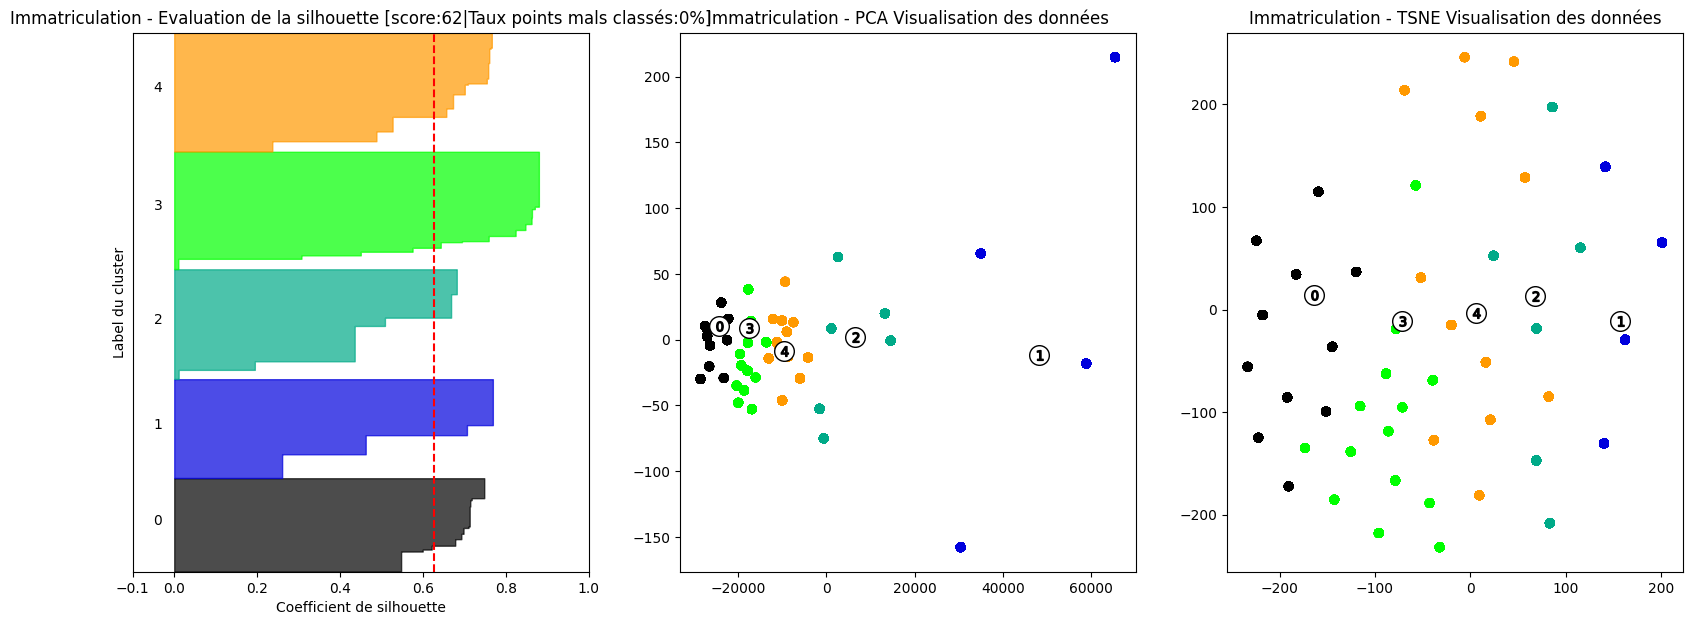

In [33]:
show_cluster2("Immatriculation",5,X_im[:20000],labels[:20000])

In [37]:
show_cluster_content(5,immatriculations2,labels)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
marques,['Peugeot' 'Volkswagen' 'Kia' 'Daihatsu' 'Audi...,['BMW' 'Mercedes'],['Volvo' 'Jaguar' 'Renault' 'Saab'],['Volkswagen' 'Audi' 'Renault' 'Mercedes' 'For...,['Renault' 'Skoda' 'BMW' 'Saab' 'Jaguar' 'Ford...
noms,['1007 1.4' 'Polo 1.2 6V' 'Picanto 1.1' 'Cuore...,['M5' 'S500'],['S80 T6' 'X-Type 2.5 V6' 'Vel Satis 3.5 V6' '...,['Golf 2.0 FSI' 'A2 1.4' 'Megane 2.0 16V' 'A20...,['Laguna 2.0T' 'Superb 2.8 V6' '120i' '9.3 1.8...
puissances,55-115,306-507,150-272,75-170,110-200
prix,7500-13750,66360-101300,34440-50500,15644-22350,22900-31790
longueurs,['courte' 'moyenne'],['très longue'],['très longue' 'longue'],['moyenne' 'courte' 'longue'],['longue' 'très longue' 'moyenne']
nbPlaces,5,5,5,5,5
nbPortes,5,5,5,5,5
nbVehicules,345888,359719,412607,439363,439055


On remarque la configuration des clusters est similaire à celle de l'entrainement

In [38]:
immatriculations2["categorie"] = immatriculations2.categorie_label.map(categories_map)
immatriculations2.head(10)

,immatriculation,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,categorie_label,categorie
0,3176 TS 67,Renault,Laguna 2.0T,170,longue,5,5,blanc,False,27300,4,Moyen
1,3721 QS 49,Volvo,S80 T6,272,très longue,5,5,noir,False,50500,2,Familliale
2,9099 UV 26,Volkswagen,Golf 2.0 FSI,150,moyenne,5,5,gris,True,16029,3,Economique
3,3563 LA 55,Peugeot,1007 1.4,75,courte,5,5,blanc,True,9625,0,Citadine
4,6963 AX 34,Audi,A2 1.4,75,courte,5,5,gris,False,18310,3,Economique
5,5592 HQ 89,Skoda,Superb 2.8 V6,193,très longue,5,5,bleu,False,31790,4,Moyen
6,674 CE 26,Renault,Megane 2.0 16V,135,moyenne,5,5,gris,False,22350,3,Economique
7,1756 PR 31,Mercedes,A200,136,moyenne,5,5,noir,True,18130,3,Economique
8,6705 GX 50,BMW,120i,150,moyenne,5,5,noir,True,25060,4,Moyen
9,4487 DR 75,Saab,9.3 1.8T,150,longue,5,5,gris,True,27020,4,Moyen


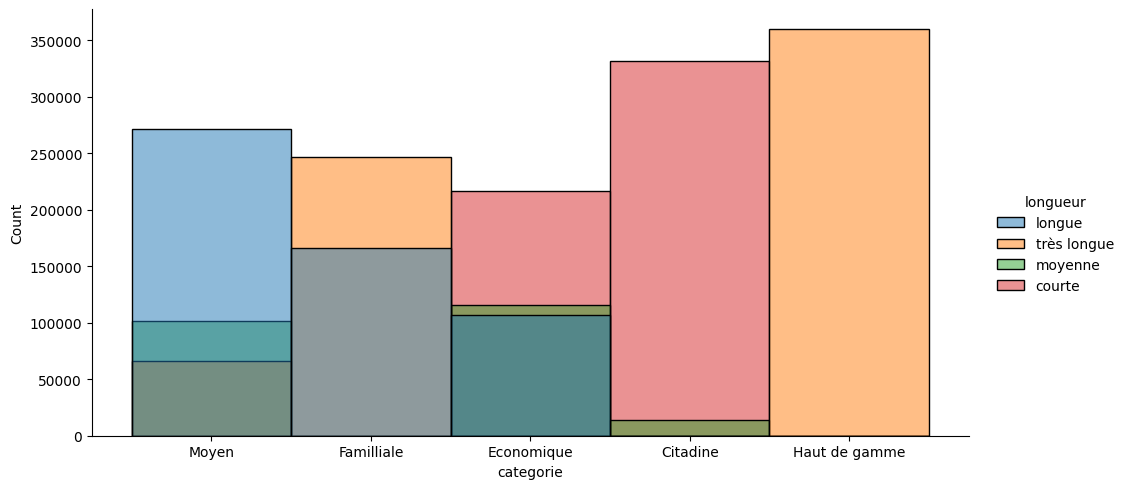

In [39]:
import seaborn as sns
sns.displot(immatriculations2,x="categorie",hue="longueur",aspect=2)

Text(0.5, 1.0, 'Joint Plot de la puissance et le prix')

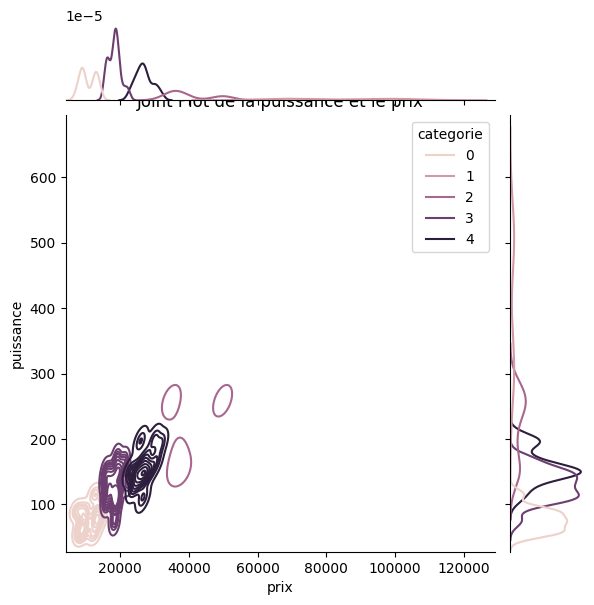

In [40]:
x = catalogue.copy()
labels = categorieClusteringModel.predict(data)
x["categorie"] = labels
sns.jointplot(x,x="prix",y="puissance",hue='categorie',kind="kde")
plt.title("Joint Plot de la puissance et le prix")

## Enregistrement des résultats

On enregistre le fichier immatriculations catégorisé et la categories_map.

In [41]:
# Enregistrement du DataFrame
with open('data_processed/clustering_immatriculations_categoriser_kmeans.pkl', 'wb') as f1:
    pickle.dump(immatriculations2, f1)

# Enregistrement de dictionnaire de mapping des labels
with open('data_processed/clustering_vehicules.categories_map_kmeans.pkl', 'wb') as f1:
    pickle.dump(categories_map, f1)

In [42]:
# Enregistrement de DataFrame au format csv
immatriculations2.to_csv("data_processed/clustering_immatriculations_categoriser_kmeans.csv")

# Enregistrement de mapper au format json
with open('data_processed/clustering_vehicules.categories_map_kmeans.json', 'w') as f1:
    f1.write(json.dumps(categories_map,indent=4))